In [ ]:
#!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Usin

In [1]:
import torch
import numpy as np
import normflows as nf
from matplotlib import pyplot as plt
from tqdm import tqdm
import sys, os
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
from PIL import Image
import matplotlib as ml
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'normflows'

In [ ]:
filename1='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-3.dat'
# Headers to skip
lines_to_skip = 5

# Defining the columns (cv = central value, sd = standard deviation)
columns=["x", "gluon_cv", "gluon_sd"]

# Loading data from txt file
# Change filename1 to another filename for data that extends to lower x
# (see exercises at the bottom of this notebook)
df = pd.read_csv(filename1,
                 sep="\s+",
                 skiprows=lines_to_skip,
                 usecols=[0,1,2],
                 names=columns)

# Splitting data randomly to train and test using the sklearn library
df_train, df_test = train_test_split(df,test_size=0.2,random_state=42)

# Sort the split data according to their x values
df_train = df_train.sort_values("x")
df_test = df_test.sort_values("x")

print("Data parsing is done!")

Data parsing is done!


0      4.480675
1      4.478519
2      4.476361
3      4.474202
4      4.472040
         ...   
993   -0.001109
994   -0.000878
996   -0.000634
997   -0.000494
999   -0.000144
Name: gluon_cv, Length: 800, dtype: float64
<class 'numpy.ndarray'>


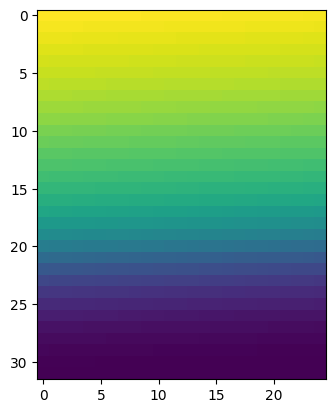

In [ ]:
print(df_train["gluon_cv"])
data = np.asarray(df_train["gluon_cv"])
print(type(data))
data=data.reshape(32,25)
plt.imshow(data, interpolation='none')
plt.show()

In [ ]:
data = np.load('Z_matrix_replica_448.npy', encoding='bytes')

<class 'numpy.ndarray'>
(15, 15)


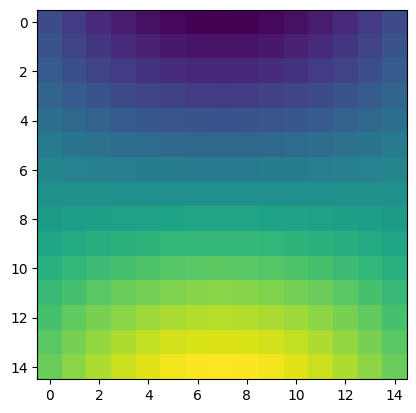

In [ ]:
print(type(data))
plt.imshow(data, interpolation='none')
print(data.shape)
plt.show()

In [ ]:
# Set up model

# Define flows
K = 32
#torch.manual_seed(0)

b = torch.tensor([0, 1])
flows = []
for i in range(K):
    s = nf.nets.MLP([2, 4, 4, 2])
    t = nf.nets.MLP([2, 4, 4, 2])
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]

# Set target and base distribution
img = data # Specify the path to your image here
target = nf.distributions.ImagePrior(img)
q0 = nf.distributions.DiagGaussian(2)

# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)
nfm = nfm.double()

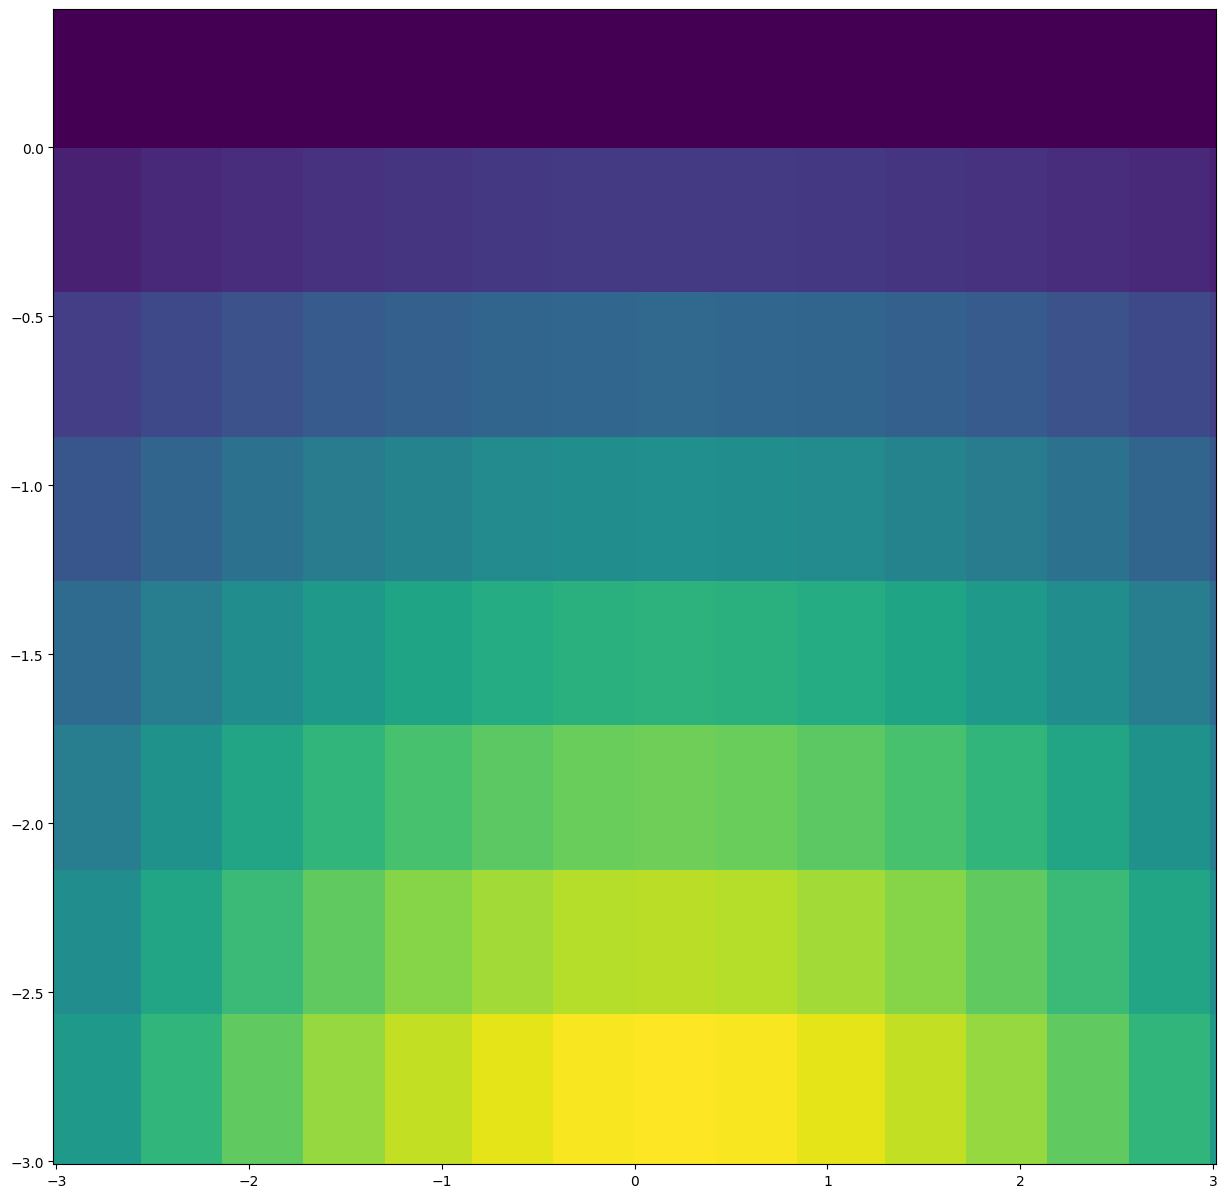

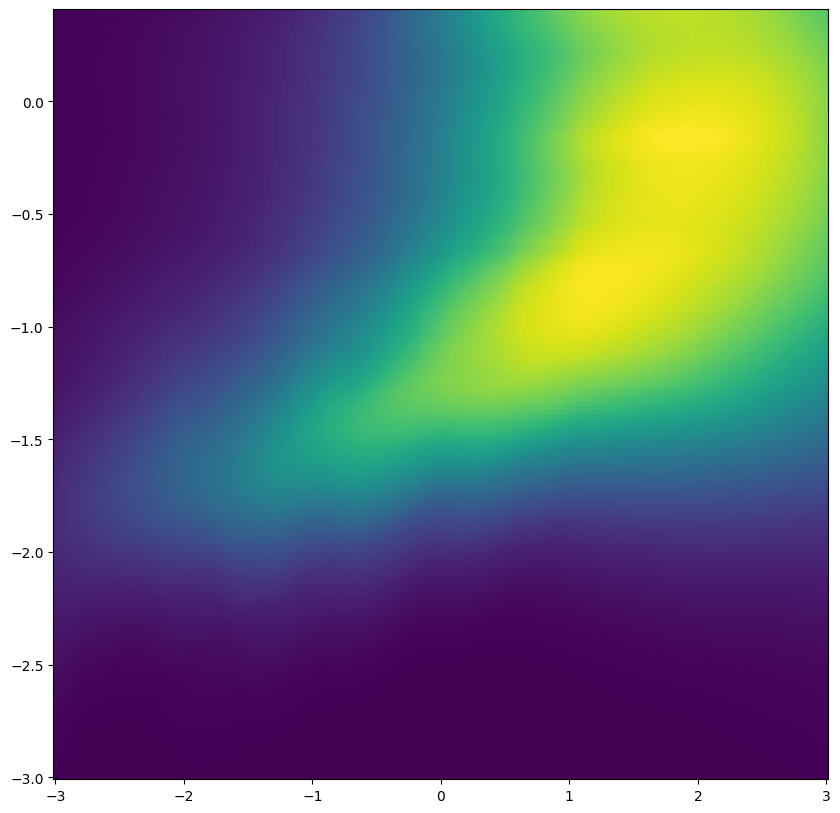

In [ ]:
# Plot prior distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3,3, grid_size), torch.linspace(.4, -3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.double().to(device)
log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.show()

# Plot initial posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.show()

 20%|█▉        | 1998/10000 [02:31<10:06, 13.19it/s]

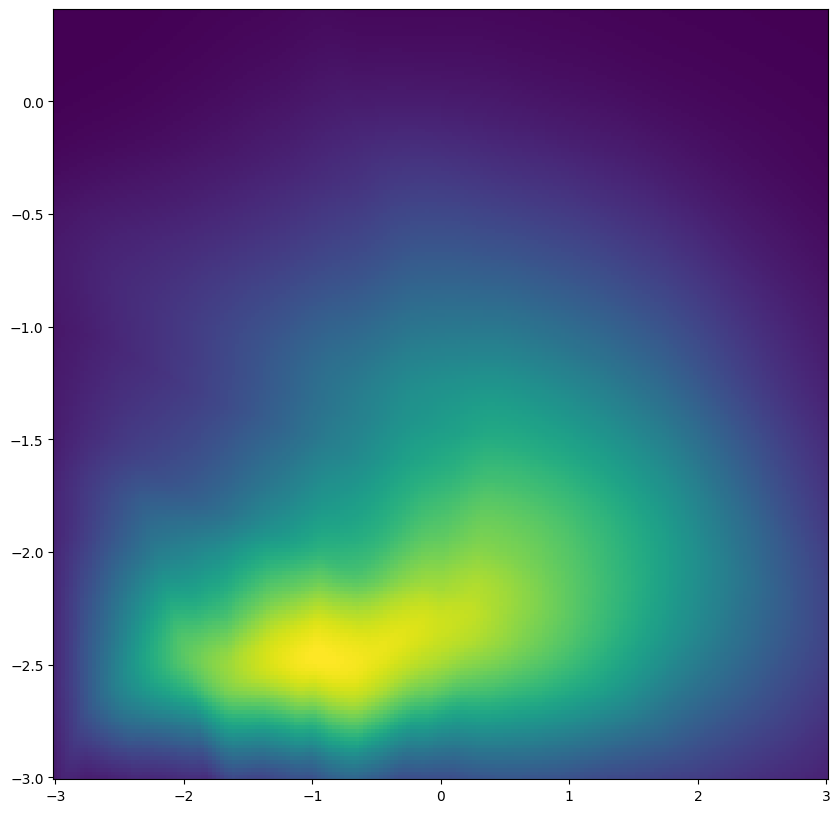

 40%|███▉      | 3999/10000 [05:01<06:56, 14.39it/s]

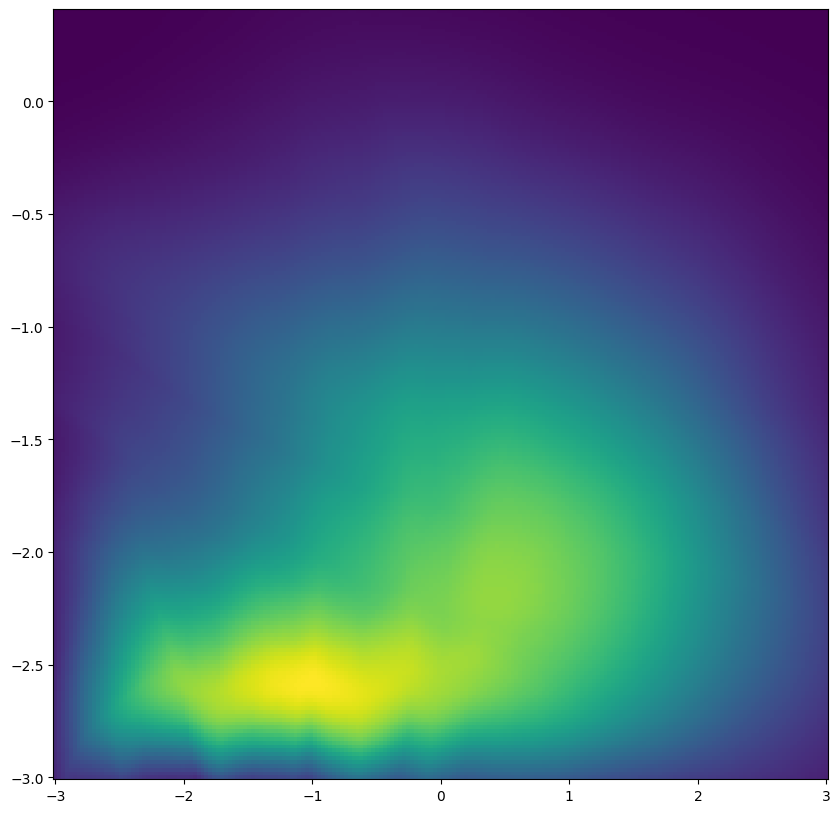

 60%|█████▉    | 5999/10000 [07:33<04:35, 14.52it/s]

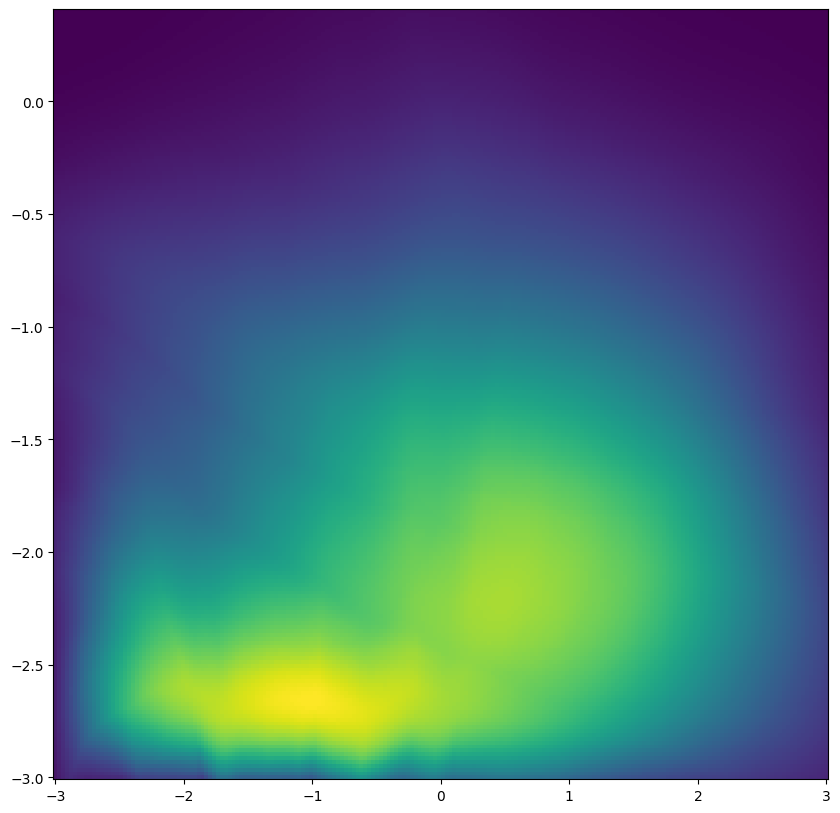

 80%|███████▉  | 7999/10000 [10:02<02:40, 12.47it/s]

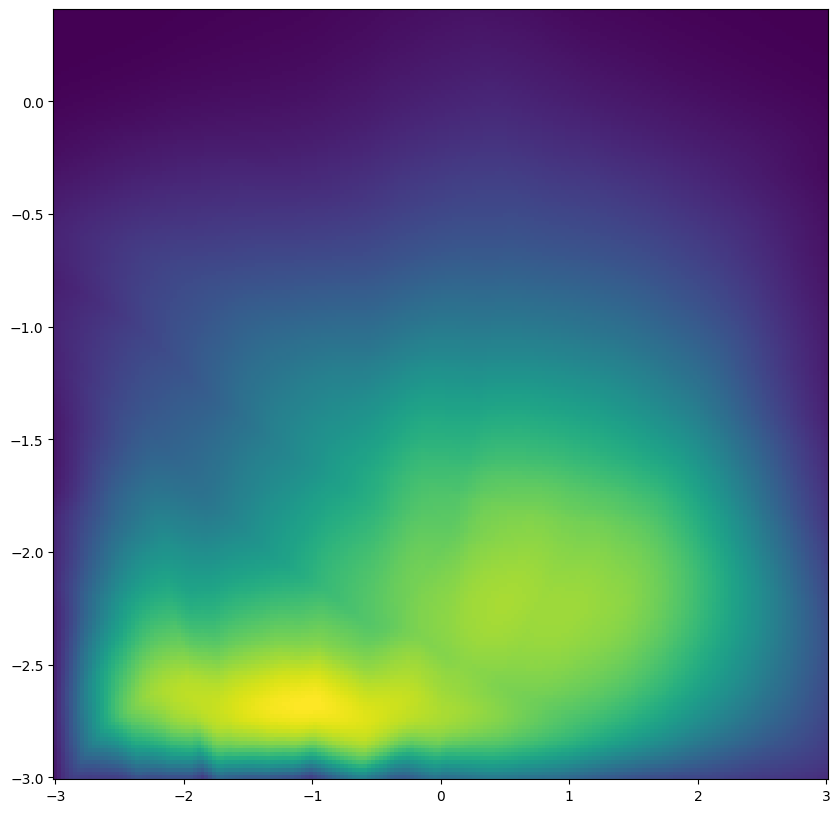

100%|█████████▉| 9999/10000 [12:35<00:00, 10.52it/s]

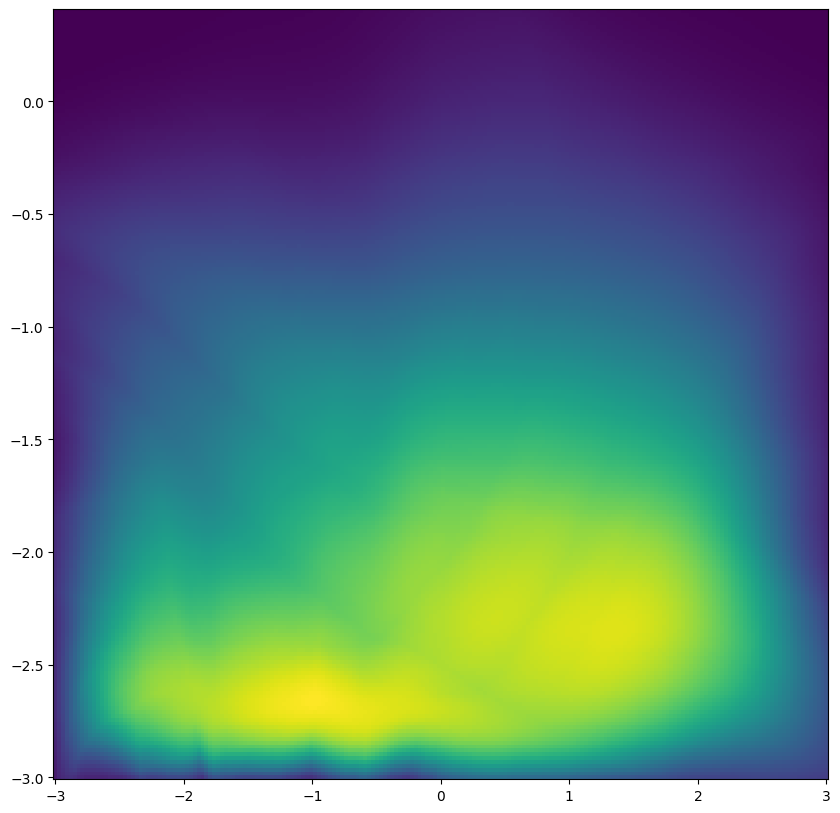

100%|██████████| 10000/10000 [12:35<00:00, 13.23it/s]


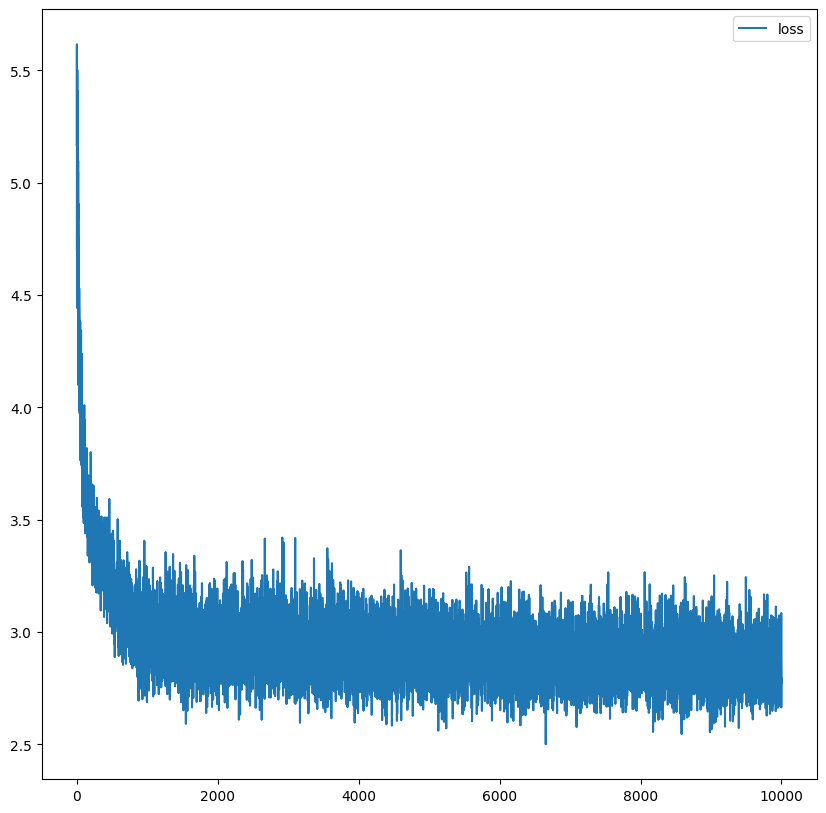

In [ ]:
# Train model
max_iter = 10000
num_samples = 2 * 16
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-4, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    x = nfm.p.sample(num_samples).double()
    loss = nfm.forward_kld(x)
    loss.backward()
    optimizer.step()

    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
        prob = torch.exp(log_prob)
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(10, 10))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.show()

plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

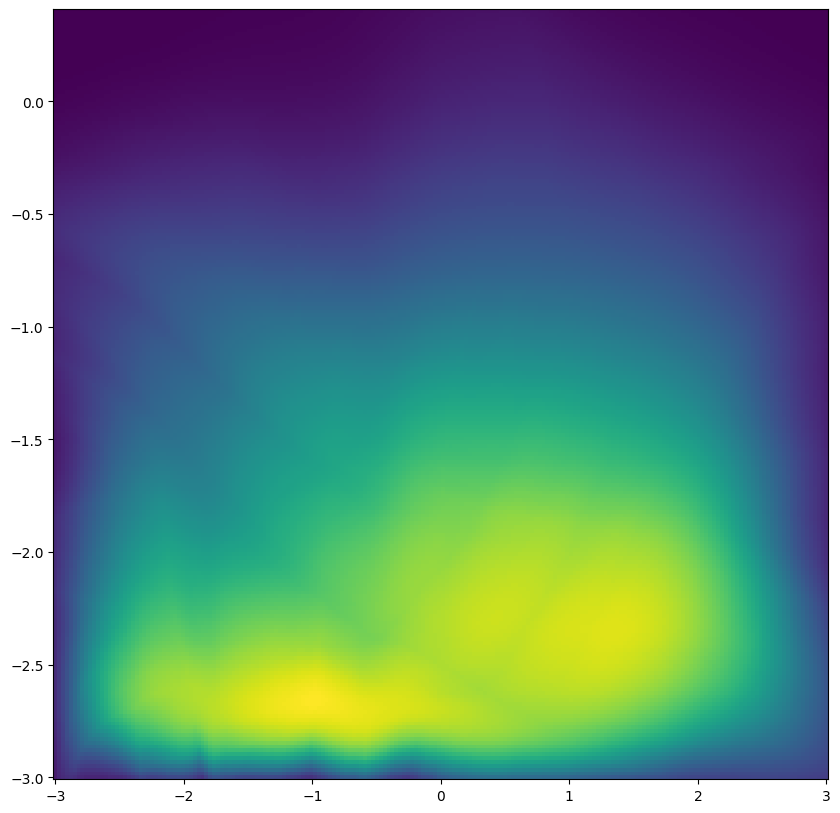

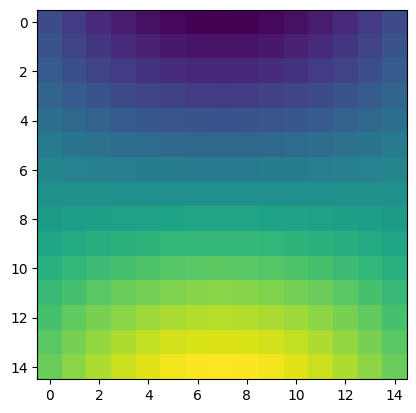

In [ ]:
# Plot learned distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.show()
plt.imshow(data, interpolation='none')
plt.show()